In [1]:
import numpy as np
import pandas as pd

def Ackley(x1, x2):
    term1 = -20 * np.exp(-0.2 * np.sqrt(0.5 * (x1**2 + x2**2)))
    term2 = -np.exp(0.5 * (np.cos(2 * np.pi * x1) + np.cos(2 * np.pi * x2)))
    return term1 + term2 + np.e + 20

def GetGrid(grid):
    x1 = np.linspace(-2, 2, grid)
    x2 = np.linspace(-2, 2, grid)
    x1, x2 = np.meshgrid(x1, x2)
    z = Ackley(x1, x2)
    return x1, x2, z

def create_dataframe(grid):
   x1, x2, z = GetGrid(grid)
   data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': z.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Power")

/tmp/ipykernel_46004/1974130748.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


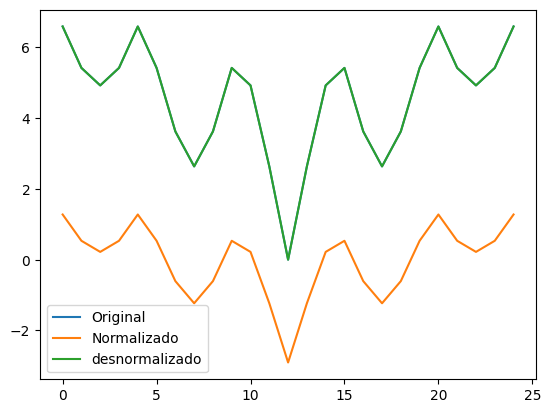

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [4]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 2.54 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [5]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [6]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-09-14 12:39:13.026149: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-14 12:39:13.026206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-14 12:39:13.028735: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-14 12:39:13.087557: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-14 12:39:21.981073: W tensorflow/compiler/tf2

In [7]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [8]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [9]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[4], [8], [12], [24], [36],
                            [4, 2], [8, 4], [12, 6], [24, 12], [36, 18]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[4], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 32ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 23ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 25ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 29ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24m

2024-09-14 12:51:40.445206: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  17
32/32 [==============================] - 1s 23ms/step
+++++++++++ [1_15] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_15] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_15] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_15] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_3_0,0.507012,-0.323765,-1.11887,-0.264273,0.470905,2.653738,1.562482,1.155893,5.308090e+13,0.686225,-1.103414,0.697032,99.506198,206.051175


DataFrame salvo em ../results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 22ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_4] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_4] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_4_0,0.535477,-0.551242,-1.172742,-3.519097,0.443715,3.109759,1.602208,0.416726,4.820509e+13,0.666119,-0.981965,0.676610,99.625145,206.170121
model_3_4_1,0.540222,-0.602647,-1.164314,-3.552003,0.439183,3.212810,1.595993,0.419760,4.753242e+13,0.662709,-0.961721,0.673146,99.645678,206.190654
model_3_4_7,0.607610,-0.629388,-1.228326,-7.072976,0.374813,3.266418,1.643196,0.744445,5.879559e+13,0.612220,-0.674196,0.621862,99.962656,206.507632
model_3_4_6,0.636814,-0.639875,-1.214184,-4.772228,0.346918,3.287441,1.632768,0.532283,5.759929e+13,0.588997,-0.549595,0.598273,100.117336,206.662312
model_3_4_5,0.638322,-0.642552,-1.215176,-4.567224,0.345477,3.292806,1.633499,0.513378,5.792297e+13,0.587773,-0.543158,0.597029,100.125660,206.670636
model_3_4_8,0.593145,-0.648941,-1.267564,-9.046359,0.388630,3.305614,1.672131,0.926419,6.093377e+13,0.623402,-0.735914,0.633220,99.890254,206.435230
model_3_4_9,0.574119,-0.689010,-1.372091,-11.189085,0.406804,3.385941,1.749210,1.124009,6.345166e+13,0.637812,-0.817090,0.647857,99.798849,206.343825
model_3_4_4,0.613839,-0.693357,-1.171759,-4.039511,0.368863,3.394656,1.601483,0.464715,5.602413e+13,0.607341,-0.647620,0.616906,99.994658,206.539635
model_3_4_2,0.558569,-0.710618,-1.188069,-4.797010,0.421657,3.429259,1.613511,0.534568,5.191388e+13,0.649352,-0.883439,0.659578,99.727124,206.272100
model_3_4_3,0.591587,-0.713441,-1.167142,-4.508928,0.390118,3.434917,1.598079,0.508003,5.706143e+13,0.624595,-0.742562,0.634431,99.882610,206.427586


DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 19ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_5] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_5] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_5_4,0.503255,-0.415091,-2.264209,0.080715,0.474494,2.836818,2.407070,1.156050,1.002538e+14,0.688835,-1.119447,0.699684,99.491011,206.035988
model_3_5_5,0.535583,-0.425067,-2.297739,0.124496,0.443614,2.856818,2.431796,1.100994,9.322283e+13,0.666044,-0.981514,0.676533,99.625600,206.170576
model_3_5_6,0.507630,-0.456886,-2.562949,-0.032377,0.470314,2.920605,2.627365,1.298269,9.229533e+13,0.685795,-1.100777,0.696595,99.508708,206.053684
model_3_5_7,0.506030,-0.458721,-2.582372,-0.058306,0.471843,2.924282,2.641687,1.330877,9.057733e+13,0.686908,-1.107604,0.697726,99.502218,206.047195
model_3_5_8,0.494554,-0.459232,-2.661890,-0.114042,0.482805,2.925307,2.700325,1.400968,8.700150e+13,0.694842,-1.156570,0.705785,99.456284,206.001260
model_3_5_3,0.593758,-0.551675,-2.017212,0.546784,0.388045,3.110627,2.224931,0.569943,8.465729e+13,0.622933,-0.733301,0.632743,99.893267,206.438243
model_3_5_0,0.615060,-0.669571,-1.852340,0.671688,0.367697,3.346972,2.103353,0.412870,8.599526e+13,0.606380,-0.642409,0.615930,100.000993,206.545970
model_3_5_1,0.606993,-0.680042,-1.910248,0.633293,0.375402,3.367963,2.146055,0.461153,8.596686e+13,0.612701,-0.676828,0.622350,99.959514,206.504491
model_3_5_2,0.603271,-0.683048,-1.933986,0.610456,0.378958,3.373988,2.163559,0.489872,8.647330e+13,0.615596,-0.692712,0.625291,99.940659,206.485635


DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Stopped at epoch:  39
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_6] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_8_8,0.612910,-0.455357,-2.187112,0.535654,0.369751,2.917539,2.350218,1.065688,1.631638e+14,0.608071,-0.651583,0.617648,99.989853,206.534829
model_3_8_7,0.608443,-0.462136,-2.253653,0.552999,0.374017,2.931128,2.399286,1.025880,1.579094e+14,0.611570,-0.670642,0.621201,99.966907,206.511883
model_3_8_4,0.591012,-0.475041,-2.467864,0.691287,0.390668,2.957000,2.557248,0.708505,1.383614e+14,0.625035,-0.745017,0.634878,99.879793,206.424769
model_3_8_2,0.576227,-0.475574,-2.465824,0.738008,0.404791,2.958068,2.555744,0.601280,1.270938e+14,0.636232,-0.808099,0.646252,99.808770,206.353746
model_3_8_3,0.580981,-0.488130,-2.517125,0.725765,0.400250,2.983239,2.593574,0.629378,1.304870e+14,0.632653,-0.787815,0.642617,99.831333,206.376310
model_3_8_6,0.606541,-0.492579,-2.414863,0.601936,0.375834,2.992158,2.518165,0.913570,1.394149e+14,0.613053,-0.678758,0.622708,99.957214,206.502190
model_3_8_5,0.607866,-0.496504,-2.441697,0.613066,0.374568,3.000026,2.537952,0.888024,1.360721e+14,0.612020,-0.673103,0.621659,99.963962,206.508938
model_3_8_1,0.582843,-0.528763,-2.540098,0.767761,0.398471,3.064696,2.610514,0.532995,1.100034e+14,0.631246,-0.779870,0.641187,99.840242,206.385218
model_3_8_0,0.565555,-0.576133,-2.578930,0.809951,0.414985,3.159658,2.639150,0.436168,7.963540e+13,0.644193,-0.853633,0.654338,99.759027,206.304003


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Stopped at epoch:  33
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_9] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_9] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_9_8,0.729506,-0.332047,-1.628599,0.657690,0.258377,2.670342,1.938363,0.794885,1.547115e+14,0.508308,-0.154106,0.516313,100.706670,207.251647
model_3_9_9,0.707176,-0.342589,-1.627743,0.596784,0.279708,2.691473,1.937732,0.936317,1.536438e+14,0.528874,-0.249384,0.537203,100.548021,207.092997
model_3_9_7,0.716151,-0.345616,-1.698516,0.645978,0.271134,2.697542,1.989921,0.822082,1.531952e+14,0.520705,-0.211088,0.528906,100.610284,207.155260
model_3_9_6,0.712546,-0.357423,-1.788671,0.671184,0.274578,2.721212,2.056402,0.763550,1.541787e+14,0.524002,-0.226472,0.532255,100.585038,207.130014
model_3_9_5,0.705606,-0.368845,-1.832178,0.686393,0.281207,2.744110,2.088485,0.728233,1.576727e+14,0.530289,-0.256080,0.538641,100.537331,207.082307
model_3_9_4,0.688612,-0.378110,-1.865669,0.668103,0.297440,2.762684,2.113182,0.770705,1.591907e+14,0.545381,-0.328590,0.553970,100.425086,206.970062
model_3_9_3,0.599022,-0.418032,-2.056448,0.607496,0.383016,2.842714,2.253865,0.911442,1.695598e+14,0.618883,-0.710838,0.628630,99.919356,206.464332
model_3_9_2,0.633178,-0.438346,-2.074539,0.692882,0.350390,2.883438,2.267205,0.713166,1.644193e+14,0.591938,-0.565106,0.601260,100.097415,206.642392
model_3_9_1,0.631085,-0.438627,-2.082138,0.696233,0.352390,2.884000,2.272809,0.705384,1.646228e+14,0.593625,-0.574039,0.602974,100.086032,206.631008
model_3_9_0,0.621968,-0.440396,-2.103287,0.687158,0.361099,2.887548,2.288404,0.726458,1.661324e+14,0.600915,-0.612939,0.610379,100.037207,206.582183


DataFrame salvo em ../results/metrics_3_9
+++++++++++ [3_10] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_10] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 22ms/step
+++++++++++ [3_10] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_10] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_10] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_10] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_10] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 23ms/step
+++++++++++ [3_10] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_10_0,0.700736,-0.371785,-1.764315,0.375333,0.285859,2.750004,2.038441,0.223913,1.492383e+14,0.534657,-0.276859,0.543078,100.504516,207.049492
model_3_10_1,0.696868,-0.396786,-1.931590,0.233594,0.289554,2.800123,2.161792,0.274720,1.451579e+14,0.538102,-0.293365,0.546577,100.478828,207.023804
model_3_10_3,0.694566,-0.436385,-2.326990,-0.648397,0.291753,2.879505,2.453366,0.590872,1.301585e+14,0.540141,-0.303186,0.548648,100.463698,207.008674
model_3_10_2,0.682712,-0.439229,-2.230230,-0.387305,0.303075,2.885207,2.382014,0.497283,1.339320e+14,0.550523,-0.353762,0.559193,100.387547,206.932523
model_3_10_4,0.679692,-0.481462,-2.472697,-1.034021,0.305961,2.969871,2.560812,0.729100,1.231080e+14,0.553137,-0.366649,0.561848,100.368598,206.913575
model_3_10_5,0.655728,-0.531834,-2.641115,-1.412573,0.328851,3.070851,2.685005,0.864792,1.162973e+14,0.573455,-0.468895,0.582487,100.224301,206.769277
model_3_10_6,0.635389,-0.567272,-2.828583,-1.820912,0.348279,3.141894,2.823247,1.011162,1.109642e+14,0.590152,-0.555675,0.599446,100.109503,206.654479
model_3_10_9,0.623777,-0.617105,-2.942543,-2.383805,0.359371,3.241794,2.907283,1.212933,1.036314e+14,0.599475,-0.605219,0.608916,100.046802,206.591778
model_3_10_8,0.618484,-0.671627,-2.916866,-2.364316,0.364426,3.351093,2.888348,1.205947,1.066419e+14,0.603677,-0.627802,0.613185,100.018861,206.563838
model_3_10_7,0.617640,-0.674540,-2.911430,-2.357384,0.365232,3.356934,2.884339,1.203462,1.069825e+14,0.604345,-0.631402,0.613863,100.014442,206.559419


DataFrame salvo em ../results/metrics_3_10
+++++++++++ [3_11] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_11] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_11] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 22ms/step
+++++++++++ [3_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_11] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [3_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_11] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_11] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_11_1,0.541108,-0.630132,-2.985536,-1.057989,0.438336,3.267909,2.938986,0.918740,9.482328e+13,0.66207,-0.957938,0.672497,99.649539,206.194515
model_3_11_0,0.626652,-0.641213,-2.938674,0.170144,0.356625,3.290122,2.904430,0.370469,9.974247e+13,0.59718,-0.592953,0.606585,100.062144,206.607120


DataFrame salvo em ../results/metrics_3_11
+++++++++++ [3_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_12] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_12] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_12] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 22ms/step
+++++++++++ [3_12] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_12] | 6 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_12] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_12] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_12] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_12_2,0.566547,-1.301925,-2.251545,0.523858,0.414036,4.614646,2.397732,0.912784,1.392693e+14,0.643457,-0.849397,0.653590,99.763602,206.308579
model_3_12_1,0.572148,-1.312085,-2.429906,0.629843,0.408686,4.635013,2.529257,0.709606,1.245278e+14,0.639286,-0.825500,0.649354,99.789614,206.334591
model_3_12_0,0.504989,-1.465417,-2.747646,0.663959,0.472837,4.942395,2.763563,0.644205,1.173377e+14,0.687631,-1.112045,0.698461,99.498009,206.042985


DataFrame salvo em ../results/metrics_3_12
+++++++++++ [3_13] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_13] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 26ms/step
+++++++++++ [3_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_13] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 28ms/step
+++++++++++ [3_13] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_13_0,0.501524,-1.279744,-2.259469,0.502183,0.476148,4.57018,2.403575,0.995515,1.387369e+14,0.690035,-1.126832,0.700902,99.484055,206.029031


DataFrame salvo em ../results/metrics_3_13
+++++++++++ [3_14] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_14] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_14] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [3_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_14] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_14] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_14] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_14_0,0.513855,-1.518297,-2.113845,0.720557,0.464369,5.048405,2.296189,0.663083,1.499250e+14,0.681446,-1.07422,0.692178,99.534152,206.079128


DataFrame salvo em ../results/metrics_3_14
+++++++++++ [3_15] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 15ms/step
+++++++++++ [3_15] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_15] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_15] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_15] | 8 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_15] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_17_8,0.682317,-1.705406,-2.871947,-0.334062,0.303453,5.423499,2.855224,0.702144,5.784772e+13,0.550866,-0.355448,0.559541,100.385058,206.930034
model_3_17_7,0.678824,-1.716680,-2.962623,-0.318082,0.306789,5.446100,2.922090,0.693733,5.994680e+13,0.553885,-0.370350,0.562609,100.363189,206.908165
model_3_17_6,0.676128,-1.973868,-2.909075,-0.295804,0.309365,5.961682,2.882603,0.682008,6.184569e+13,0.556206,-0.381855,0.564965,100.346468,206.891445
model_3_17_5,0.666682,-2.396738,-2.842899,-0.272544,0.318388,6.809406,2.833803,0.669766,6.506736e+13,0.564259,-0.422158,0.573145,100.288971,206.833947
model_3_17_0,0.479918,-2.850378,-2.751400,-0.465832,0.496786,7.718813,2.766331,0.771498,7.851162e+13,0.704830,-1.219018,0.715931,99.399193,205.944169
model_3_17_1,0.502705,-3.173214,-2.748975,-0.518838,0.475019,8.365999,2.764543,0.799396,7.523522e+13,0.689216,-1.121792,0.700071,99.488800,206.033776
model_3_17_3,0.626970,-3.485702,-2.825968,-0.409796,0.356320,8.992441,2.821318,0.742005,6.697593e+13,0.596926,-0.591594,0.606327,100.063851,206.608827
model_3_17_4,0.624577,-3.667387,-2.882792,-0.443027,0.358607,9.356663,2.863221,0.759495,6.889690e+13,0.598838,-0.601806,0.608269,100.051058,206.596035
model_3_17_2,0.558094,-4.196607,-2.908187,-0.648060,0.422112,10.417585,2.881948,0.867408,7.039057e+13,0.649701,-0.885467,0.659933,99.724971,206.269947


DataFrame salvo em ../results/metrics_3_17
+++++++++++ [3_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_18] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_18] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_18] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_18] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 23ms/step
+++++++++++ [3_18] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_18] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_18_9,0.496170,-1.378110,-3.459953,-3.102896,0.481261,4.767372,3.288827,1.853918,3.984553e+13,0.693730,-1.149673,0.704655,99.462691,206.007667
model_3_18_8,0.530443,-1.391007,-3.152165,-2.638992,0.448523,4.793226,3.061860,1.644300,4.060351e+13,0.669719,-1.003441,0.680266,99.603590,206.148566
model_3_18_1,0.678911,-1.698463,-2.757151,-0.121171,0.306707,5.409580,2.770572,0.506608,5.791728e+13,0.553811,-0.369982,0.562533,100.363727,206.908703
model_3_18_4,0.610980,-1.701013,-2.471561,-1.183751,0.371594,5.414694,2.559974,0.986740,5.112849e+13,0.609585,-0.659819,0.619186,99.979905,206.524881
model_3_18_0,0.683521,-1.712540,-2.851130,0.029738,0.302302,5.437801,2.839873,0.438419,5.776332e+13,0.549820,-0.350309,0.558479,100.392655,206.937631
model_3_18_2,0.643413,-1.748609,-2.444343,-0.712802,0.340614,5.510109,2.539903,0.773940,5.535998e+13,0.583621,-0.521438,0.592813,100.154011,206.698987
model_3_18_5,0.561135,-1.761212,-2.565733,-1.779395,0.419207,5.535374,2.629417,1.255886,4.104566e+13,0.647462,-0.872492,0.657659,99.738782,206.283758
model_3_18_3,0.634666,-1.789998,-2.451792,-0.834695,0.348970,5.593081,2.545396,0.829018,5.386465e+13,0.590737,-0.558760,0.600040,100.105541,206.650517
model_3_18_7,0.562394,-1.828957,-2.589370,-1.839706,0.418004,5.671181,2.646848,1.283138,4.202158e+13,0.646532,-0.867118,0.656714,99.744530,206.289506
model_3_18_6,0.561599,-1.875014,-2.579262,-1.810874,0.418763,5.763511,2.639394,1.270110,4.144199e+13,0.647119,-0.870509,0.657310,99.740901,206.285877


DataFrame salvo em ../results/metrics_3_18
+++++++++++ [3_19] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_19] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 22ms/step
+++++++++++ [3_19] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_19] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_19] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [3_19]